# Open the box - Estimate $n^{\beta\beta}_E$


## Objetices

Access the full data set and estimate the number of signal events

Estimate the $n^{\beta\beta}_E$ events in the enlarged energy window.

Set a limit or a confidence interval for $\mathcal{T}_{1/2}^{\beta\beta0\nu}$ at 95 % CL

Compute the p-value of the null hypothesis

## Analysis

In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Importing modules

In [45]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [46]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2


In [47]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import core.confint as confint  # Confidence Intervals 
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # plotting for fanal
import notebooks.guide.collpars as collpars # collaboration specific parameters
pltext.style()

### Main Parameters

In [48]:
coll          = collpars.collaboration
sel_ntracks   = collpars.sel_ntracks
sel_eblob2    = collpars.sel_eblob2
sel_erange    = collpars.sel_erange
sel_eroi      = collpars.sel_eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : {:6d}'.format(sel_ntracks))
print('Blob-2 energy range       : {:6.3f}  MeV'.format(sel_eblob2))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*sel_erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*sel_eroi))

Collaboration             : new_beta
number of tracks range    :      1
Blob-2 energy range       :  0.400  MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [49]:
n_Bi_RoI  = collpars.n_Bi_RoI
n_Tl_RoI  = collpars.n_Tl_RoI

n_Bi_E    = collpars.n_Bi_E
n_Tl_E    = collpars.n_Tl_E

print('Number Bi events in RoI = {:6.3f}'.format(n_Bi_RoI))
print('Number Tl events in RoI = {:6.3f}'.format(n_Tl_RoI))
print('Number Bi events in E   = {:6.3f}'.format(n_Bi_E))
print('Number Tl events in E   = {:6.3f}'.format(n_Tl_E))

Number Bi events in RoI = 21.765
Number Tl events in RoI =  4.008
Number Bi events in E   = 25.276
Number Tl events in E   = 150.816


## Access the data

In [50]:
# set the path to the data directory and filenames
dirpath = rootpath+'/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

# access the simulated data (DataFrames) for the different samples (Bi, Tl, bb) located in the data file
mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

# set the names of the samples
# set the names of the samples
mc_samples         = [mcbi, mctl, mcbb] # list of the mc DFs
sample_names       = ['Bi', 'Tl', 'bb']
sample_names_latex = [ r'$^{214}$Bi', r'$^{208}$Tl', r'$\beta\beta0\nu$',] # str names of the mc samples

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/data/fanal_new_beta.h5


In [51]:
datab = pd.read_hdf(dirpath + filename, key = 'data/blind')
datar = pd.read_hdf(dirpath + filename, key = 'data/roi')
data  = pd.concat((datab, datar)) # concatenate blind and roi-data into one data DF

print("Total events in data set  = {:d}".format(len(data)))

Total events in data set  = 22063


### Energy distribution for selected events

Number of expected backgrounds events in E window = 25.773
Number of expected total events in E windoes      = 171


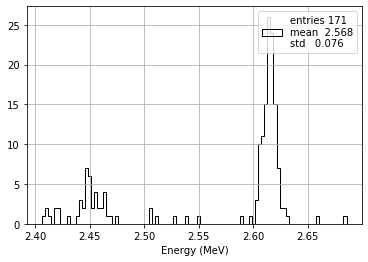

In [52]:
mask1 = (data.E >= sel_erange[0]) & (data.E < sel_erange[1])

mask2 = mask1 & (data.num_tracks <= sel_ntracks)
mask3 = mask2 & (data.blob2_E >= sel_eblob2)

pltext.hist(data.E[mask3], 100);
plt.xlabel("Energy (MeV)");

nobs = sum(mask3)
nbkg = n_Bi_RoI + n_Tl_RoI

print("Number of expected backgrounds events in E window = {:6.3f}".format(nbkg))
print("Number of expected total events in E windoes      = {:d}".format(nobs))

### Define the fitter

In [53]:
# list of the analisys selection variables names and ranges
ntracks_range = (sel_ntracks, sel_ntracks + 0.1)
eblob2_range  = (sel_eblob2, sel_erange[1]) # MeV

varnames  = ['num_tracks', 'blob2_E', 'E']
varranges = [ntracks_range, eblob2_range, sel_erange]
print('ana varnames  : ', varnames)
print('ana varranges : ', varranges)

# list of the reference selction variable names and rages to get pdfs for the MC
refnames  = ['num_tracks', 'E']
refranges = [ntracks_range, sel_erange]
print('ref varnames  : ', refnames)
print('ref varranges : ', refranges)

ana varnames  :  ['num_tracks', 'blob2_E', 'E']
ana varranges :  [(1, 1.1), (0.4, 2.7), (2.4, 2.7)]
ref varnames  :  ['num_tracks', 'E']
ref varranges :  [(1, 1.1), (2.4, 2.7)]


In [54]:
def nevts_total(factor = 1.):
    """ returns the total number of events (Bi, Tl, bb), 
    The expected number of bb events in the RoI is a **factor = 1.** of the number of the expected Bi events in RoI
    """
    n_Bi_RoI    = collpars.n_Bi_RoI
    eff_bb_RoI  = collpars.eff_bb_RoI
    n_Bi_total  = collpars.n_Bi_total
    n_Tl_total  = collpars.n_Tl_total
    n_bb_total  = factor * n_Bi_RoI/eff_bb_RoI
    nevts       = (n_Bi_total, n_Tl_total, n_bb_total)
    return np.array(nevts)

def nevts_in_E(n_total):
    """ returns the number of expected events in the enlarged energy windows: (Bi, Tl, bb) 
    given a total number of events (Bi, Tl, bb)
    """
    eff_Bi_E      = collpars.eff_Bi_E
    eff_Tl_E      = collpars.eff_Tl_E
    eff_bb_E      = collpars.eff_bb_RoI
    nBi, nTl, nbb = n_total
    nevts         = (nBi * eff_Bi_E, nTl * eff_Tl_E, nbb * eff_bb_E)
    return np.array(nevts)

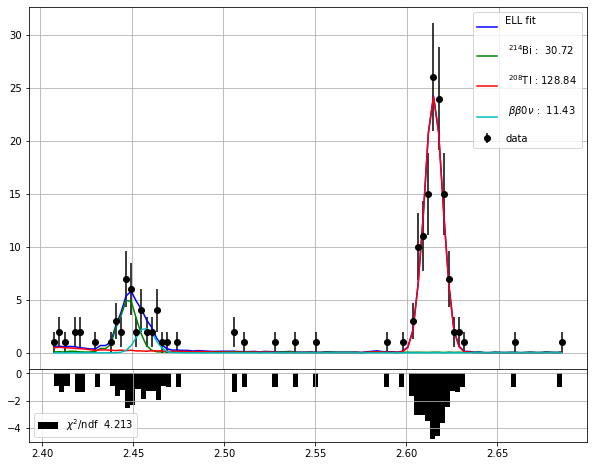

In [55]:
factor      = 1.
n_total     = nevts_total(factor)
n_E         = nevts_in_E(n_total)

# define the fit
fit         = fn.prepare_fit_ell(mc_samples, n_total, varnames, varranges, refnames, refranges)

result, values, \
ell, n_est  = fit(data)
n_est = result.x if result.success else n_E

pltfn.plot_fit_ell(values, n_est, ell, parnames = sample_names_latex)

In [56]:
for i, ni in enumerate(n_total[1:]):
    print('Number of {:s} total events = {:6.3f}'.format(sample_names[i], ni))

for i, ni in enumerate(n_E[1:]):
    print('Number of {:s} expected events in E window = {:6.3f}'.format(sample_names[i], ni))

for i, ni in enumerate(n_est):
    print('Number of {:s} estimated events in E window = {:6.3f}'.format(sample_names[i], ni))

Number of Bi total events = 20659.771
Number of Tl total events = 41.936
Number of Bi expected events in E window = 150.816
Number of Tl expected events in E window = 21.765
Number of Bi estimated events in E window = 30.723
Number of Tl estimated events in E window = 128.844
Number of bb estimated events in E window = 11.433


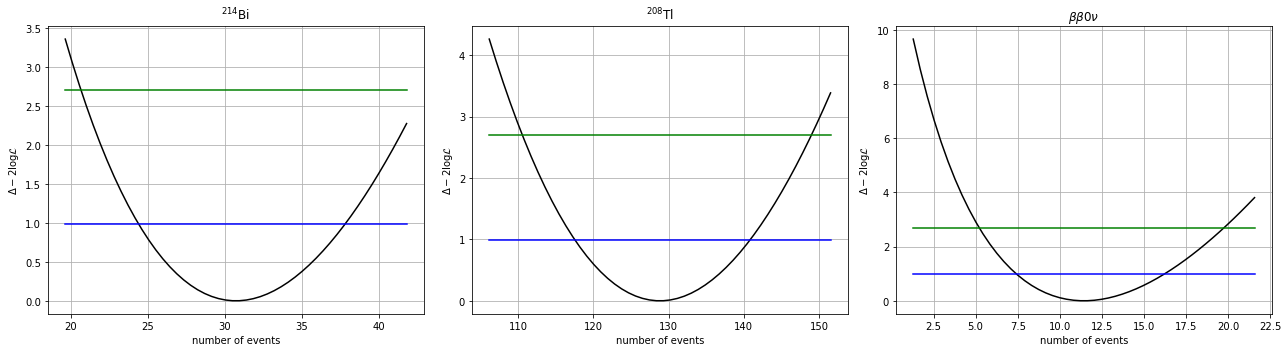

In [57]:
nis, tmus = fn.tmu_scan(values, n_est, ell, sizes = (2., 2., 3.))
pltfn.plot_tmu_scan(nis, tmus, titles = sample_names_latex)

In [58]:
cl    = 0.95
mucis = [efit.tmu_conf_int(ni, tmu, cl) for ni, tmu in zip(nis, tmus)]
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = ({:5.2f}, {:5.2f})'.format(sample_names[i], 100*cl, *ci))

Number of Bi events CI at   95 % CL = (19.64, 41.81)
Number of Tl events CI at   95 % CL = (108.00, 151.55)
Number of bb events CI at   95 % CL = ( 4.60, 21.58)


In [59]:
for i, ci in enumerate(mucis):
    print('Number of {:s} events CI at {:4.0f} % CL = {:5.2f}  {:5.2f} +{:5.2f}'.format(sample_names[i], 100*cl, 
                                                                                        result.x[i],
                                                                                        *(ci - n_est[i])))

Number of Bi events CI at   95 % CL = 30.72  -11.09 +11.09
Number of Tl events CI at   95 % CL = 128.84  -20.85 +22.70
Number of bb events CI at   95 % CL = 11.43  -6.83 +10.14


In [60]:
q0 = efit.tmu(values, ell, n_est, 0, ipos = 2)
z0 = np.sqrt(q0)
p0 = 1 - stats.norm.cdf(z0)
print('null hypothesis p-value {:1.2e}, {:4.2f} sigmas'.format(p0, z0))

null hypothesis p-value 8.59e-05, 3.76 sigmas


In [61]:
exposure = collpars.exposure
eff      = collpars.acc_bb * collpars.eff_bb_E # total signal selection efficiency in the E window
n_bb_E   = n_est[-1] # estimated number of bb  in E
tau      = fn.half_life(n_bb_E, exposure, eff) # tau_1/2

print('number of bb0nu events in E  : {:6.3f}'.format(n_bb_E))
print('exposure                     : {:6.2f} kg y'.format(exposure))
print('total signal efficiency      : {:6.3f}'.format(eff))
print('bb0nu half-life              : {:6.2e} y '.format(tau))

n_bb_ci    = mucis[-1] # nbbs of the CL  
utaus = [fn.half_life(n_bb_i, exposure, eff) for n_bb_i in n_bb_ci]
utaus.reverse()
print('bb0nu half-life {:d}% CL       : [{:6.2e}, {:6.2e}] y '.format(int(100*cl), *utaus))

number of bb0nu events in E  : 11.433
exposure                     : 1000.00 kg y
total signal efficiency      :  0.410
bb0nu half-life              : 9.91e+25 y 
bb0nu half-life 95% CL       : [5.25e+25, 2.46e+26] y 


## Write out

In [62]:
write = True
if (write):
    of = open('../guide/collpars.py', 'a')
    of.write("n_bb_E           = {:6.3f} \n".format(n_bb_E))
    of.write("eff_bb_E_tau     = {:6.4f} \n".format(eff))
    of.write("Tau_fitexp       = {:6.2e} #y \n".format(tau))
    of.write("Tau_fitexp_ci    = [{:6.2e}, {:6.2e}] # y at {:d}% CL \n".format(*utaus, int(100*cl)))
    of.write("pvalue_fitext    = {:6.2e} \n".format(p0))
    of.close()